# Library Download

In [1]:
import warnings
warnings.filterwarnings("ignore")

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
    
#if IN_COLAB:
#    !git clone -qq https://github.com/Intelligent-Systems-Phystech/ProjectTemplate.git /tmp/repo
#    !python3 -m pip install -qq /tmp/repo/src/ && rm -rf /tmp/repo
#!pip install yfinance --upgrade --no-cache-dir
#!pip install tsfell
#!pip install pyarrow
#!pip install fastparquet

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


# Library Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import scipy.stats
import time
import tqdm
import catboost

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, ParameterGrid, RepeatedKFold, cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from datetime import datetime

# Environment Setup

In [2]:
plt.rcParams['figure.figsize'] = 11, 7
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

# Data Loading

In [12]:
btc = pd.read_parquet('./../data/binance-futures_book_snapshot_25_2024-11-01_BTCUSDT.parquet')
pepe = pd.read_parquet('./../data/binance-futures_book_snapshot_25_2024-11-01_1000PEPEUSDT.parquet')
eth = pd.read_parquet('./../data/binance-futures_book_snapshot_25_2024-11-01_ETHUSDT.parquet')
sol = pd.read_parquet('./../data/binance-futures_book_snapshot_25_2024-11-01_SOLUSDT.parquet')
mew = pd.read_parquet('./../data/binance-futures_book_snapshot_25_2024-11-01_MEWUSDT.parquet')

# Data Analysis

First we wil explore the most obvious differences in the microstructure of the instruments btc and pepe:

In [13]:
btc.head()

,local_timestamp,asks[0].price,asks[0].amount,bids[0].price,bids[0].amount,asks[1].price,asks[1].amount,bids[1].price,bids[1].amount,asks[2].price,...,bids[22].price,bids[22].amount,asks[23].price,asks[23].amount,bids[23].price,bids[23].amount,asks[24].price,asks[24].amount,bids[24].price,bids[24].amount
0,1730419200789651,70322.0,8.178,70321.9,6.357,70322.1,0.002,70321.8,0.004,70322.2,...,70317.6,5.076,70325.1,0.002,70317.5,0.066,70325.2,1.191,70317.4,0.003
1,1730419204075109,70322.0,7.787,70321.9,0.744,70322.1,0.002,70321.8,0.004,70322.2,...,70317.6,5.076,70325.1,0.002,70317.5,0.066,70325.2,1.191,70317.4,0.003
2,1730419204129205,70322.0,9.605,70321.9,0.187,70322.1,0.002,70317.7,0.194,70322.2,...,70314.6,0.033,70325.2,1.191,70314.3,0.004,70325.3,0.996,70314.2,0.003
3,1730419204175118,70322.0,6.244,70321.9,0.580,70322.1,0.032,70317.7,0.194,70322.2,...,70314.6,0.033,70325.2,1.191,70314.3,0.004,70325.3,0.996,70314.2,0.003
4,1730419204227085,70322.0,4.909,70321.9,2.413,70322.1,0.032,70320.0,0.002,70322.2,...,70314.8,0.002,70325.2,1.191,70314.6,0.033,70325.3,0.996,70314.3,0.004


In [14]:
pepe.head()

,local_timestamp,asks[0].price,asks[0].amount,bids[0].price,bids[0].amount,asks[1].price,asks[1].amount,bids[1].price,bids[1].amount,asks[2].price,...,bids[22].price,bids[22].amount,asks[23].price,asks[23].amount,bids[23].price,bids[23].amount,asks[24].price,asks[24].amount,bids[24].price,bids[24].amount
0,1730419201051657,0.009116,462474,0.009116,1423216,0.009116,2745,0.009115,2745,0.009116,...,0.009113,494574,0.009118,126005,0.009113,252601,0.009119,407960,0.009113,271960
1,1730419202554942,0.009116,542550,0.009116,1351513,0.009116,2745,0.009115,2745,0.009116,...,0.009113,494574,0.009118,126005,0.009113,252601,0.009119,407960,0.009113,271960
2,1730419204074041,0.009116,401496,0.009116,1293027,0.009116,2745,0.009115,2745,0.009116,...,0.009113,244319,0.009118,204951,0.009113,255672,0.009119,407960,0.009113,271960
3,1730419204129207,0.009118,81699,0.009116,762292,0.009118,220174,0.009116,63425,0.009118,...,0.009113,309599,0.009120,549,0.009113,268829,0.009120,648678,0.009113,402760
4,1730419204174582,0.009119,212603,0.009116,762292,0.009119,549,0.009116,63425,0.009119,...,0.009113,309599,0.009122,560,0.009113,379958,0.009122,577800,0.009113,402760


Additionally, we will calculate all necessary features for our anlysis:

In [15]:
def get_mid_price(market_data: pd.DataFrame) -> pd.Series:
    return (market_data['asks[0].price'] + market_data['bids[0].price'])/2


def get_step(market_data: pd.DataFrame):
    return str(market_data.iloc[0]['asks[0].price'])[::-1].find('.')


def get_rel_step(market_data: pd.DataFrame) -> pd.Series:
    step=10**(-get_step(market_data))
    return step/market_data['mid_price']


def get_bid_volume(market_data: pd.DataFrame, level_amount=25) -> pd.Series:
    return sum([market_data['bids[{}].amount'.format(i)] for i in range(0, level_amount)])


def get_ask_volume(market_data: pd.DataFrame, level_amount=25) -> pd.Series:
    return sum([market_data['asks[{}].amount'.format(i)] for i in range(0, level_amount)])


def get_imbalance(market_data: pd.DataFrame, level_amount=25) -> pd.Series:
    bid_volume = get_bid_volume(market_data, level_amount)
    ask_volume = get_ask_volume(market_data, level_amount)
    return bid_volume / (bid_volume + ask_volume)


def get_vamp_bid(market_data: pd.DataFrame, level_amount=25) -> pd.Series:
    return sum([market_data['bids[{}].amount'.format(i)]*market_data['bids[{}].price'.format(i)] \
                   for i in range(0, level_amount)]) / (get_ask_volume(market_data, level_amount)+get_bid_volume(market_data, level_amount))

def get_vamp_ask(market_data: pd.DataFrame, level_amount=25) -> pd.Series:
    return sum([market_data['asks[{}].amount'.format(i)]*market_data['asks[{}].price'.format(i)] \
                   for i in range(0, level_amount)]) / (get_ask_volume(market_data, level_amount)+get_bid_volume(market_data, level_amount))

def get_vamp(market_data: pd.DataFrame, level_amount=25) -> pd.Series:
    return (get_vamp_ask(market_data, level_amount) + get_vamp_bid(market_data, level_amount))/2


extractors = {'mid_price': get_mid_price, 'rel_step': get_rel_step, 'bid_volume': get_bid_volume, 'ask_volume': get_ask_volume, 'imbalance': get_imbalance, 'vamp': get_vamp}

def extract_features(market_data: pd.DataFrame, extractos: list):
    for feature_name, extractor in extractors.items():
        market_data[feature_name] = extractor(market_data)

In [16]:
tickers = [btc, pepe, eth, sol, mew]

for ticker in tickers:
    ticker.index = pd.to_datetime(ticker['local_timestamp'])
    extract_features(ticker, extractors)

In [ ]:
pepe.iloc[0]['asks[0].price'], pepe.iloc[0]['asks[1].price'], btc.iloc[0]['asks[0].price']

(0.0091156, 0.0091157, 70322.0)

The first difference that is easy to spot in these instruments is the price step, for btc it is $0.1$ and for the 1000pepe it is $0.0000001$. Let us calculate mean relative price step for each instrument:

In [ ]:
np.mean(btc['rel_step']), np.mean(pepe['rel_step'])

(1.4332122958765926e-06, 1.1089515703257899e-05)

As we can see the relative step for the btc is by a magnitude smaller than for pepe. This essentially means that btc's price change occurs more frequently takes up a multitude of levels(e.g. 10 or 20), while the pepe's price changes rarely and for fewer levels. Now let's take a look at the distribtution of the imbalance:

Text(0.5, 1.0, 'Imbalance Distribution')

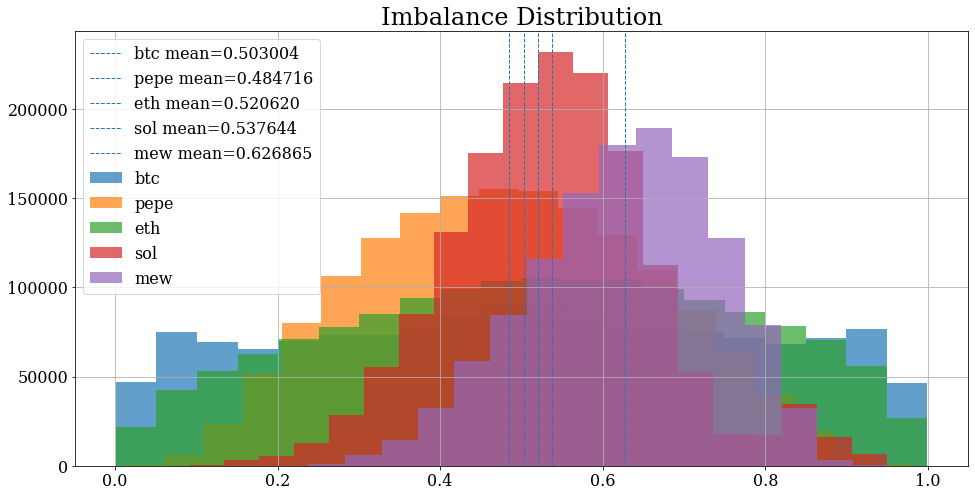

In [ ]:
plt.figure(figsize=(16, 8))
levels=25

tickers_dict = {'btc': btc, 'pepe': pepe, 'eth': eth, 'sol': sol, 'mew': mew}

for name, ticker in tickers_dict.items():
    ticker_imb = get_imbalance(ticker, levels)
    plt.hist(ticker_imb, bins=20, alpha=0.7, label=name)
    plt.axvline(ticker_imb.mean(), linestyle='dashed', linewidth=1, label=name+' mean={:.6f}'.format(ticker_imb.mean()))

plt.legend(loc='best')
plt.grid()
plt.title('Imbalance Distribution')

As we can see the pepe ticker is slightly more disbalanced to the sell side, while the btc - slightly more to the buy side. Additionally, the pepe's imbalance distribution is morereminicent of normal distribution with 0.5 mean, while, btc's imbalance is more similar to uniform distribution, which hits at more active trading for thisinstrument.

Now let's take a look at one of the volatility metrics - the market depth at best bid and ask. Let's plot which share total trading volume is occupied by both best bid and ask. To make the difference more clear we will take a look at 3 best levels:

Text(0.5, 1.0, 'Best bid/ask share Distribution')

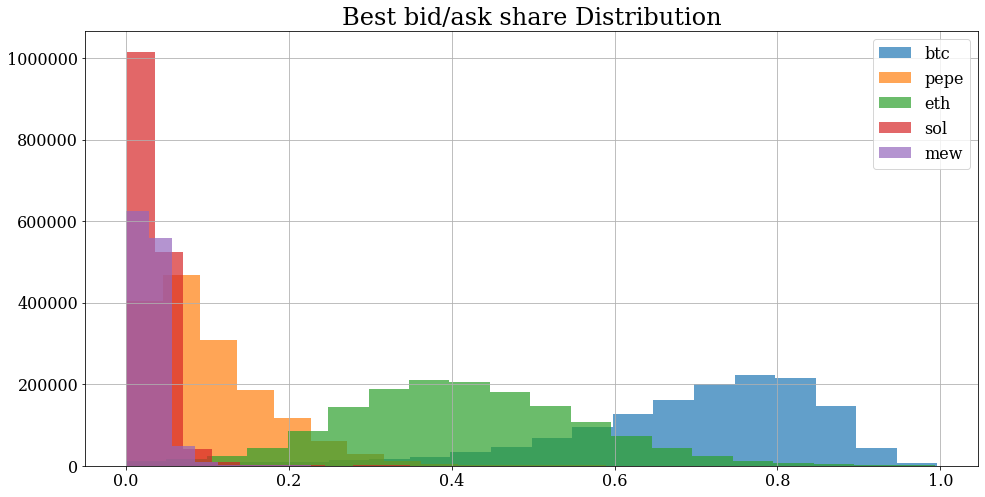

In [21]:
levels=2

plt.figure(figsize=(16, 8))

for name, ticker in tickers_dict.items():
    plt.hist((get_bid_volume(ticker, levels)+get_ask_volume(ticker, levels))/(ticker['bid_volume']+ticker['ask_volume']), bins=20, alpha=0.7, label=name)


plt.legend(loc='best')
plt.grid()
plt.title('Best bid/ask share Distribution')

Here we can clearly see that btc's orderbook already contains the majority of the trading volume on first 3 levels, while pepe does not. This addtionally allows us to identify another difference in the microstructure - the shape of the orderbook. This difference is to be expected as market makers make more aggressive limit orders on the instrument with rebates.

# 2) BTCUSDT, ETHUSDT, 1000PEPEUSDT, SOLUSDT and MEWUSDT <a name="task2"></a>

Let's first take a look at the behaviour of midprices for all instruments:

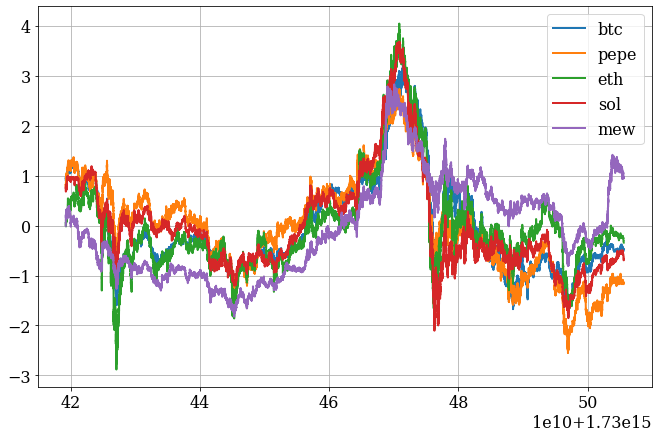

In [ ]:
ticker_names = ['btc', 'pepe', 'eth', 'sol', 'mew']
scaler = StandardScaler()

for ticker_name, ticker in zip(ticker_names, tickers):
    scaled_price = scaler.fit_transform(ticker['mid_price'].values.reshape(-1, 1))
    plt.plot(ticker['local_timestamp'], scaled_price, label=ticker_name)

plt.legend(loc='best')
plt.grid()

It's rather complicated to identify dependencies on this graph, therefore we shall attempt lagged correlation analysis.

In [ ]:
def market_corr(market_data1, market_data2, max_lag_ms=10, freq='1ms'):


    common_index = pd.date_range(start=min(market_data1.index.min(), market_data2.index.min()),
                                end=max(market_data1.index.max(), market_data2.index.max()),
                                freq=freq)

    aligned_data1 = market_data1.reindex(common_index).ffill()
    aligned_data2 = market_data2.reindex(common_index).ffill()

    max_lag_ms = 10
    correlations = []

    for lag in range(-max_lag_ms, max_lag_ms+1):
        if lag < 0:
            shifted_data1 = aligned_data1.shift(-lag)  # Shift 1 forward
            corr = shifted_data1.corr(aligned_data2)
        else:
            shifted_data2 = aligned_data2.shift(lag)  # Shift 2 forward
            corr = aligned_data1.corr(shifted_data2)

    correlations.append((lag, corr))

    best_lag, best_corr = max(correlations, key=lambda x: abs(x[1]))
    print(f"Best lag: {best_lag} ms, Correlation: {best_corr}")

    # Step 4: Interpret the result
    if best_lag < 0:
        print("Instrument 1 is likely the leader, Instrument 2 is the follower.")
    else:
        print("Instrument 2 is likely the leader, Instrument 1 is the follower.")

    return best_lag, best_corr

Let's look at the correlation between two instruments - pepe and btc:

In [ ]:
print(market_corr(pepe['mid_price'], btc['mid_price'], max_lag_ms=100, freq='0.01ms'))
print(market_corr(pepe['vamp'], btc['vamp'], max_lag_ms=100, freq='0.01ms'))

Best lag: 10 ms, Correlation: 0.8640017847960245
Instrument 2 is likely the leader, Instrument 1 is the follower.
(10, 0.8640017847960245)
Best lag: 10 ms, Correlation: 0.8637540049997311
Instrument 2 is likely the leader, Instrument 1 is the follower.
(10, 0.8637540049997311)


As we can see we have recieved quite a sensible result - btc is a more famous and fundemental crypto currency, therefore itmakes sence that other less popular coins will follow it. Both VAMP and mid-priceof btc with a 10 milisencond lag are good indicators for VAMP and mid-price of pepe.

In [ ]:
print(market_corr(eth['mid_price'], btc['mid_price'], max_lag_ms=100, freq='0.01ms'))
print(market_corr(eth['vamp'], btc['vamp'], max_lag_ms=100, freq='0.01ms'))

Best lag: 10 ms, Correlation: 0.8605051553066818
Instrument 2 is likely the leader, Instrument 1 is the follower.
(10, 0.8605051553066818)
Best lag: 10 ms, Correlation: 0.8607693248107209
Instrument 2 is likely the leader, Instrument 1 is the follower.
(10, 0.8607693248107209)


Once again we can see that btc overpowers another instrument. Let's attempt to chekc dependency between two less famous coins:

In [ ]:
print(market_corr(mew['mid_price'], pepe['mid_price'], max_lag_ms=100, freq='0.01ms'))
print(market_corr(mew['vamp'], pepe['vamp'], max_lag_ms=100, freq='0.01ms'))

Best lag: 10 ms, Correlation: 0.40110944586061137
Instrument 2 is likely the leader, Instrument 1 is the follower.
(10, 0.40110944586061137)
Best lag: 10 ms, Correlation: 0.4062589649623723
Instrument 2 is likely the leader, Instrument 1 is the follower.
(10, 0.4062589649623723)


Here we can see that the correlation is much less apparent. Indeed, while pepe still has some leadirship it is not as debatable as in the case of btc. Let's take a look atthe behaviour of sol coin and its dependencies:

In [ ]:
print(market_corr(sol['mid_price'], pepe['mid_price'], max_lag_ms=100, freq='0.01ms'))
print(market_corr(sol['vamp'], pepe['vamp'], max_lag_ms=100, freq='0.01ms'))

Best lag: 10 ms, Correlation: 0.9061554525797053
Instrument 2 is likely the leader, Instrument 1 is the follower.
(10, 0.9061554525797053)
Best lag: 10 ms, Correlation: 0.9078063484145498
Instrument 2 is likely the leader, Instrument 1 is the follower.
(10, 0.9078063484145498)


And the result is that sol is even more correlated with pepe than btc, now let's compare these two coins:

In [ ]:
print(market_corr(sol['mid_price'], btc['mid_price'], max_lag_ms=100, freq='0.01ms'))
print(market_corr(sol['vamp'], btc['vamp'], max_lag_ms=100, freq='0.01ms'))

Best lag: 10 ms, Correlation: 0.8849068311121521
Instrument 2 is likely the leader, Instrument 1 is the follower.
(10, 0.8849068311121521)
Best lag: 10 ms, Correlation: 0.8842369113120572
Instrument 2 is likely the leader, Instrument 1 is the follower.
(10, 0.8842369113120572)


Nevertheless, sol still loses againstthe btc. As a result we can come to the conclusion that mid price, VAMP and even potentially micro-price(which is not implemented in this notebook, butdescribed in Stoikov's article) are strong indicators for other instruments in case of present price discovery.

In [ ]:
print(market_corr((pepe['ask_volume']+pepe['bid_volume'])/np.mean(pepe['ask_volume']+pepe['bid_volume']), (btc['ask_volume']+btc['bid_volume'])/np.mean(btc['ask_volume']+btc['bid_volume']), max_lag_ms=100, freq='0.01ms'))

Best lag: 10 ms, Correlation: 0.1615803581947272
Instrument 2 is likely the leader, Instrument 1 is the follower.
(10, 0.1615803581947272)
